<a href="https://colab.research.google.com/github/acedesci/scanalytics/blob/master/EN/S05_Descriptive_Analytics/M5_preprocessing_backup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install prophet --quiet

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
#from prophet import Prophet

calendar = pd.read_csv('https://raw.githubusercontent.com/acedesci/scanalytics/refs/heads/master/EN/data/M5/original/calendar.csv')
ca_m5_csv = 'https://raw.githubusercontent.com/acedesci/scanalytics/refs/heads/master/EN/data/M5/original/CA_2Cat_sales_train_evaluation.csv'


ALL_AGGREGATION_LEVELS = [
    [],
    ['state_id'],
    ['store_id'],
    ['cat_id'],
    ['dept_id'],
    ['state_id', 'cat_id'],
    ['state_id', 'dept_id'],
    ['store_id', 'cat_id'],
    ['store_id', 'dept_id'],
    ['item_id'],
    ['state_id', 'item_id'],
    ['item_id', 'store_id']
]
INTERVALS = [0.99, 0.95, 0.75, 0.5]

def read_sales(filename, aggregation_list, ALL_AGGREGATION_LEVELS):
    sales = pd.read_csv(filename)
    agg_sales = []
    queried_sales = []
    for level in ALL_AGGREGATION_LEVELS:
        if len(level) == 0:
            agg = pd.DataFrame(sales.sum(numeric_only=True)).T
            agg['id'] = 'Total_X'
        elif len(level) == 1:
            agg = sales.groupby(level).sum(numeric_only=True).reset_index()
            agg['id'] = agg[level[0]] + '_X'
            agg.drop(level, axis=1, inplace=True)
        else:
            agg = sales.groupby(level).sum(numeric_only=True).reset_index()
            agg['id'] = agg[level[0]] + '_' + agg[level[1]]
            agg.drop(level, axis=1, inplace=True)
        agg_sales.append(agg)
        if aggregation_list == level:
          queried_sales.append(agg)

    sales = pd.concat(agg_sales)
    sales.set_index('id', inplace=True)
    sales.columns = calendar.date[:len(sales.columns)]

    q_sales = pd.concat(queried_sales)
    q_sales.set_index('id', inplace=True)
    q_sales.columns = calendar.date[:len(q_sales.columns)]

    return sales, q_sales

def get_univariate_ts(ds_sales, index=0):
    ts_data = ds_sales.iloc[index]
    ts_data = ts_data.T.reset_index()
    ts_data.columns = ['ds', 'y']
    return ts_data

def resample_ts(ts_data, freq='W'):
    ts_data = ts_data.set_index('ds')
    ts_data.index = pd.to_datetime(ts_data.index)
    data = ts_data.resample('W').sum()[1:]
    data['ds'] = data.index
    data = data[['ds','y']][data['ds']>='2013-01-01']
    #print(data)
    return data






In [ ]:
# single series with Prophet format ['ds','y']

ts_dataframe = pd.DataFrame()

aggregation_list = ['store_id', 'cat_id']
sales_valid, queried_sales = read_sales(ca_m5_csv, aggregation_list, ALL_AGGREGATION_LEVELS)

i = 0
ts_data = get_univariate_ts(queried_sales, 0)
uni_data = resample_ts(ts_data, freq='W')
#print(uni_data)
ts_dataframe['y'] = uni_data['y']

ts_dataframe

from google.colab import drive

drive.mount('/content/drive')

ts_dataframe.to_csv('/content/drive/My Drive/m5data_CA_uni_cat_store.csv')

Mounted at /content/drive


In [ ]:
# Multiple series with index as 'ds' and each column containing the series name

ts_dataframe = pd.DataFrame()


aggregation_list = ['state_id', 'item_id']
sales_valid, queried_sales = read_sales(ca_m5_csv, aggregation_list, ALL_AGGREGATION_LEVELS)

count = 0
max_count = 500

for i in range(len(queried_sales.index)):
  ts_data = get_univariate_ts(queried_sales, i)
  uni_data = resample_ts(ts_data, freq='W')
  # print(uni_data)
  if(sum(uni_data['y'][:13]) > 0):
    ts_dataframe[queried_sales.index[i]] = uni_data['y']

  count += 1
  if count >= max_count: break

ts_dataframe

<ipython-input-8-15896746e41d>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ts_dataframe[queried_sales.index[i]] = uni_data['y']
<ipython-input-8-15896746e41d>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ts_dataframe[queried_sales.index[i]] = uni_data['y']
<ipython-input-8-15896746e41d>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

,CA_HOBBIES_1_002,CA_HOBBIES_1_004,CA_HOBBIES_1_005,CA_HOBBIES_1_006,CA_HOBBIES_1_007,CA_HOBBIES_1_008,CA_HOBBIES_1_009,CA_HOBBIES_1_010,CA_HOBBIES_1_011,CA_HOBBIES_1_012,...,CA_HOBBIES_2_068,CA_HOBBIES_2_069,CA_HOBBIES_2_073,CA_HOBBIES_2_074,CA_HOBBIES_2_075,CA_HOBBIES_2_076,CA_HOBBIES_2_078,CA_HOBBIES_2_079,CA_HOBBIES_2_080,CA_HOBBIES_2_083
ds,,,,,,,,,,,,,,,,,,,,,
2013-01-06,6,85,33,39,4,0,32,20,1,18,...,8,2,7,3,0,0,10,3,1,0
2013-01-13,5,52,43,38,7,2,35,16,3,15,...,5,0,1,1,52,40,3,5,2,30
2013-01-20,8,85,24,32,9,0,44,19,3,11,...,13,7,3,3,75,28,2,4,1,12
2013-01-27,7,66,40,47,8,89,38,17,4,18,...,10,5,5,4,79,35,1,3,3,24
2013-02-03,7,88,34,47,4,251,30,14,5,13,...,10,7,2,4,85,27,4,4,3,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-24,9,79,32,19,11,182,33,19,0,9,...,7,8,3,3,34,7,4,0,3,1
2016-05-01,1,99,31,27,9,180,46,19,1,10,...,11,0,3,3,44,4,5,3,4,10
2016-05-08,1,70,52,19,9,167,25,16,2,8,...,15,1,7,7,34,6,2,3,7,7


In [ ]:
# summarizing stats and categories of the series

item_stats = pd.DataFrame(columns=['item','class','mean', 'std', 'nz_mean', 'nz_std', 'adi', 'cv2'])

# smooth, erratic, intermittent, and lumpy.
# They identified an item as smooth when CV2 ≤ 0.49 and
# ADI ≤ 1.32, erratic when CV2 >0.49 and ADI ≤ 1.32,
# intermittent when CV2 ≤ 0.49 and ADI >1.32, and
# lumpy when CV2 >0.49 and ADI >1.32.

for item in range(len(ts_dataframe.columns)):
  #if 'CA_4' in queried_sales.index[item] and 'HOUSEHOLD' in queried_sales.index[item]:
  if 'H' in ts_dataframe.columns[item]:
    ts_data = ts_dataframe[ts_dataframe.columns[item]]
    #print(ts_data)

    mean = ts_data.mean()
    std = ts_data.std()

    adi = len(ts_data)/len(ts_data[ts_data >= 0.01])

    non_zero_rows = ts_data > 0
    mean_non_zero = ts_data[non_zero_rows].mean()
    std_non_zero = ts_data[non_zero_rows].std()
    cv2 = (mean_non_zero/std_non_zero)**2

    item_class = ''
    if cv2 <= 0.49 and adi <= 1.32:
      item_class = 'smooth'
    elif cv2 > 0.49 and adi <= 1.32:
      item_class = 'erratic'
    elif cv2 <= 0.49 and adi > 1.32:
      item_class = 'intermittent'
    elif cv2 > 0.49 and adi > 1.32:
      item_class = 'lumpy'

    item_stats.loc[item] = [ts_dataframe.columns[item], item_class, mean, std, mean_non_zero, std_non_zero, adi, cv2]



item_stats


,item,class,mean,std,nz_mean,nz_std,adi,cv2
0,CA_HOBBIES_1_002,erratic,6.039548,3.749790,6.108571,3.714632,1.011429,2.704256
1,CA_HOBBIES_1_004,erratic,92.242938,18.144395,92.242938,18.144395,1.000000,25.845283
2,CA_HOBBIES_1_005,erratic,29.661017,11.549710,29.661017,11.549710,1.000000,6.595230
3,CA_HOBBIES_1_006,erratic,23.847458,10.555826,23.847458,10.555826,1.000000,5.103871
4,CA_HOBBIES_1_007,erratic,6.983051,2.590355,6.983051,2.590355,1.000000,7.267280
...,...,...,...,...,...,...,...,...
390,CA_HOBBIES_2_076,erratic,8.129944,6.695492,8.993750,6.465678,1.106250,1.934878
391,CA_HOBBIES_2_078,erratic,3.694915,3.435713,4.605634,3.241919,1.246479,2.018248
392,CA_HOBBIES_2_079,lumpy,1.615819,1.522326,2.251969,1.339086,1.393701,2.828185
393,CA_HOBBIES_2_080,erratic,2.124294,1.479530,2.350000,1.374521,1.106250,2.923028


In [ ]:
cls_counts = item_stats['class'].value_counts()

print(cls_counts)
n_max_items = 500
item_shortlisted = []

for cls in item_stats['class'].unique():
  #print(cls)
  item_shortlisted.extend(item_stats[item_stats['class'] == cls].head(min(n_max_items, cls_counts[cls]))['item'])
  #item_shortlisted.extend(item_stats[item_stats['class'] == cls].sort_values(by=['cv2'], ascending=True).head(min(n_max_items, cls_counts[cls]))['item'])

selected_sales = ts_dataframe[item_shortlisted]
selected_sales

class
erratic    365
lumpy       30
Name: count, dtype: int64


,CA_HOBBIES_1_002,CA_HOBBIES_1_004,CA_HOBBIES_1_005,CA_HOBBIES_1_006,CA_HOBBIES_1_007,CA_HOBBIES_1_008,CA_HOBBIES_1_009,CA_HOBBIES_1_010,CA_HOBBIES_1_011,CA_HOBBIES_1_012,CA_HOBBIES_1_018,CA_HOBBIES_1_023,CA_HOBBIES_1_049,CA_HOBBIES_1_052,CA_HOBBIES_1_054,CA_HOBBIES_1_077,CA_HOBBIES_1_098,CA_HOBBIES_1_099,CA_HOBBIES_1_106,CA_HOBBIES_1_112
ds,,,,,,,,,,,,,,,,,,,,
2013-01-06,6,85,33,39,4,0,32,20,1,18,1,35,3,1,1,15,22,32,5,11
2013-01-13,5,52,43,38,7,2,35,16,3,15,0,41,7,0,2,21,20,40,9,4
2013-01-20,8,85,24,32,9,0,44,19,3,11,0,35,13,1,0,10,29,32,7,6
2013-01-27,7,66,40,47,8,89,38,17,4,18,2,36,8,0,4,19,30,48,9,7
2013-02-03,7,88,34,47,4,251,30,14,5,13,0,30,13,1,3,13,28,37,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-24,9,79,32,19,11,182,33,19,0,9,2,43,18,1,5,5,22,36,13,6
2016-05-01,1,99,31,27,9,180,46,19,1,10,3,62,8,1,3,11,31,45,13,3
2016-05-08,1,70,52,19,9,167,25,16,2,8,4,39,14,4,4,13,27,41,10,3


In [ ]:
# save the multiple series dataframe

from google.colab import drive

drive.mount('/content/drive')

# selected_sales.to_csv('/content/drive/My Drive/m5data_CA_item_store_n25_rand.csv')
selected_sales.to_csv('/content/drive/My Drive/m5data_CA_item_state_all.csv')

Mounted at /content/drive


In [ ]:
item_stats

,item,class,mean,std,nz_mean,nz_std,adi,cv2
0,HOBBIES_1_001_CA_1,erratic,5.259887,7.579895,6.650000,7.964783,1.264286,0.697100
1,HOBBIES_1_001_CA_2,erratic,7.367232,9.099554,8.412903,9.261558,1.141935,0.825132
2,HOBBIES_1_001_CA_3,erratic,5.604520,7.130407,6.841379,7.322602,1.220690,0.872884
3,HOBBIES_1_001_CA_4,erratic,2.790960,3.549380,3.406897,3.644815,1.220690,0.873709
4,HOBBIES_1_002_CA_1,erratic,4.389831,5.066659,5.078431,5.119017,1.156863,0.984206
...,...,...,...,...,...,...,...,...
100,HOBBIES_1_026_CA_1,intermittent,1.519774,5.949685,5.489796,10.370476,3.612245,0.280230
101,HOBBIES_1_026_CA_2,intermittent,0.576271,1.565284,1.593750,2.279785,2.765625,0.488711
102,HOBBIES_1_026_CA_3,intermittent,1.497175,3.477402,3.154762,4.511015,2.107143,0.489085
103,HOBBIES_1_026_CA_4,smooth,6.870056,18.601382,7.195266,18.977204,1.047337,0.143757


from matplotlib import pyplot as plt
item_stats['mean'].plot(kind='hist', bins=20, title='mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
item_stats['std'].plot(kind='hist', bins=20, title='std')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
item_stats['nz_mean'].plot(kind='hist', bins=20, title='nz_mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
item_stats['nz_std'].plot(kind='hist', bins=20, title='nz_std')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
item_stats.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
item_stats.plot(kind='scatter', x='mean', y='std', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
item_stats.plot(kind='scatter', x='std', y='nz_mean', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
item_stats.plot(kind='scatter', x='nz_mean', y='nz_std', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
item_stats.plot(kind='scatter', x='nz_std', y='adi', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
item_stats['mean'].plot(kind='line', figsize=(8, 4), title='mean')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
item_stats['std'].plot(kind='line', figsize=(8, 4), title='std')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
item_stats['nz_mean'].plot(kind='line', figsize=(8, 4), title='nz_mean')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
item_stats['nz_std'].plot(kind='line', figsize=(8, 4), title='nz_std')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(item_stats['class'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(item_stats, x='mean', y='class', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(item_stats['class'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(item_stats, x='std', y='class', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(item_stats['class'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(item_stats, x='nz_mean', y='class', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(item_stats['class'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(item_stats, x='nz_std', y='class', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/ha0tamvk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/y73ps516.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92595', 'data', 'file=/tmp/tmp806o25su/ha0tamvk.json', 'init=/tmp/tmp806o25su/y73ps516.json', 'output', 'file=/tmp/tmp806o25su/prophet_modelc3_bnitw/prophet_model-20241223072318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds   y
0   2013-01-06   2
1   2013-01-13  19
2   2013-01-20   0
3   2013-01-27   9
4   2013-02-03   3
..         ...  ..
172 2016-04-24   0
173 2016-05-01   3
174 2016-05-08   7
175 2016-05-15   1
176 2016-05-22   4

[177 rows x 2 columns]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/ry_bc7nb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/i4yyl2w3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20324', 'data', 'file=/tmp/tmp806o25su/ry_bc7nb.json', 'init=/tmp/tmp806o25su/i4yyl2w3.json', 'output', 'file=/tmp/tmp806o25su/prophet_modelzcucl1a7/prophet_model-20241223072319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds   y
0   2013-01-06   7
1   2013-01-13   1
2   2013-01-20   0
3   2013-01-27   6
4   2013-02-03   1
..         ...  ..
172 2016-04-24  20
173 2016-05-01   4
174 2016-05-08   5
175 2016-05-15   9
176 2016-05-22  21

[177 rows x 2 columns]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/c3fb9u90.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/aruvnvjv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67219', 'data', 'file=/tmp/tmp806o25su/c3fb9u90.json', 'init=/tmp/tmp806o25su/aruvnvjv.json', 'output', 'file=/tmp/tmp806o25su/prophet_model4jmjpehb/prophet_model-20241223072319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds   y
0   2013-01-06   6
1   2013-01-13   0
2   2013-01-20   3
3   2013-01-27   8
4   2013-02-03   1
..         ...  ..
172 2016-04-24   6
173 2016-05-01  11
174 2016-05-08   7
175 2016-05-15   8
176 2016-05-22   3

[177 rows x 2 columns]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/hnf8umme.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/bj56633k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71877', 'data', 'file=/tmp/tmp806o25su/hnf8umme.json', 'init=/tmp/tmp806o25su/bj56633k.json', 'output', 'file=/tmp/tmp806o25su/prophet_modellh069u40/prophet_model-20241223072319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds   y
0   2013-01-06   0
1   2013-01-13   0
2   2013-01-20   2
3   2013-01-27   2
4   2013-02-03   2
..         ...  ..
172 2016-04-24   1
173 2016-05-01  10
174 2016-05-08   3
175 2016-05-15   3
176 2016-05-22   3

[177 rows x 2 columns]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/zb37go2_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/74rybhw4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28660', 'data', 'file=/tmp/tmp806o25su/zb37go2_.json', 'init=/tmp/tmp806o25su/74rybhw4.json', 'output', 'file=/tmp/tmp806o25su/prophet_modelqg_c1wh3/prophet_model-20241223072320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds   y
0   2013-01-06   0
1   2013-01-13   4
2   2013-01-20   0
3   2013-01-27   3
4   2013-02-03   0
..         ...  ..
172 2016-04-24   7
173 2016-05-01  11
174 2016-05-08   2
175 2016-05-15   2
176 2016-05-22   2

[177 rows x 2 columns]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/geg9z0l5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/zw8g03db.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87198', 'data', 'file=/tmp/tmp806o25su/geg9z0l5.json', 'init=/tmp/tmp806o25su/zw8g03db.json', 'output', 'file=/tmp/tmp806o25su/prophet_modelwbwtf3ri/prophet_model-20241223072320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds  y
0   2013-01-06  4
1   2013-01-13  0
2   2013-01-20  2
3   2013-01-27  4
4   2013-02-03  0
..         ... ..
172 2016-04-24  3
173 2016-05-01  6
174 2016-05-08  9
175 2016-05-15  9
176 2016-05-22  3

[177 rows x 2 columns]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/gct1rtcm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/dhdfyxrh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21245', 'data', 'file=/tmp/tmp806o25su/gct1rtcm.json', 'init=/tmp/tmp806o25su/dhdfyxrh.json', 'output', 'file=/tmp/tmp806o25su/prophet_modelsn3zgub3/prophet_model-20241223072321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds   y
0   2013-01-06  27
1   2013-01-13   7
2   2013-01-20   4
3   2013-01-27  14
4   2013-02-03  16
..         ...  ..
172 2016-04-24   6
173 2016-05-01  10
174 2016-05-08  10
175 2016-05-15  10
176 2016-05-22  10

[177 rows x 2 columns]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/i_b0n6y3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/1yjm2zfr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48344', 'data', 'file=/tmp/tmp806o25su/i_b0n6y3.json', 'init=/tmp/tmp806o25su/1yjm2zfr.json', 'output', 'file=/tmp/tmp806o25su/prophet_model3qusvs9q/prophet_model-20241223072321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds   y
0   2013-01-06   5
1   2013-01-13  24
2   2013-01-20   1
3   2013-01-27  17
4   2013-02-03   3
..         ...  ..
172 2016-04-24   2
173 2016-05-01  11
174 2016-05-08   6
175 2016-05-15   8
176 2016-05-22  11

[177 rows x 2 columns]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/p3356e72.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/3jvbxcss.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44063', 'data', 'file=/tmp/tmp806o25su/p3356e72.json', 'init=/tmp/tmp806o25su/3jvbxcss.json', 'output', 'file=/tmp/tmp806o25su/prophet_modelyf_gl9b6/prophet_model-20241223072322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds  y
0   2013-01-06  0
1   2013-01-13  0
2   2013-01-20  0
3   2013-01-27  0
4   2013-02-03  0
..         ... ..
172 2016-04-24  9
173 2016-05-01  2
174 2016-05-08  0
175 2016-05-15  1
176 2016-05-22  3

[177 rows x 2 columns]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/srrqz8eg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/3cq3ez9i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51015', 'data', 'file=/tmp/tmp806o25su/srrqz8eg.json', 'init=/tmp/tmp806o25su/3cq3ez9i.json', 'output', 'file=/tmp/tmp806o25su/prophet_modelljxrazv5/prophet_model-20241223072322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds   y
0   2013-01-06  12
1   2013-01-13   4
2   2013-01-20  10
3   2013-01-27   0
4   2013-02-03  15
..         ...  ..
172 2016-04-24   4
173 2016-05-01  12
174 2016-05-08  10
175 2016-05-15  15
176 2016-05-22  19

[177 rows x 2 columns]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/1qih20s3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/0rhtwyla.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28806', 'data', 'file=/tmp/tmp806o25su/1qih20s3.json', 'init=/tmp/tmp806o25su/0rhtwyla.json', 'output', 'file=/tmp/tmp806o25su/prophet_modelyqhtyvqc/prophet_model-20241223072322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds  y
0   2013-01-06  0
1   2013-01-13  4
2   2013-01-20  3
3   2013-01-27  0
4   2013-02-03  0
..         ... ..
172 2016-04-24  2
173 2016-05-01  1
174 2016-05-08  0
175 2016-05-15  3
176 2016-05-22  0

[177 rows x 2 columns]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/wzkfdxkv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/pk5_12iu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86401', 'data', 'file=/tmp/tmp806o25su/wzkfdxkv.json', 'init=/tmp/tmp806o25su/pk5_12iu.json', 'output', 'file=/tmp/tmp806o25su/prophet_modelfr7_tz3j/prophet_model-20241223072323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds   y
0   2013-01-06   3
1   2013-01-13   2
2   2013-01-20   5
3   2013-01-27   2
4   2013-02-03   2
..         ...  ..
172 2016-04-24  15
173 2016-05-01  17
174 2016-05-08  19
175 2016-05-15  19
176 2016-05-22  19

[177 rows x 2 columns]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/pwrz9oe7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/ovo8duvg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4451', 'data', 'file=/tmp/tmp806o25su/pwrz9oe7.json', 'init=/tmp/tmp806o25su/ovo8duvg.json', 'output', 'file=/tmp/tmp806o25su/prophet_modelzpncg499/prophet_model-20241223072323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds   y
0   2013-01-06  25
1   2013-01-13  41
2   2013-01-20  32
3   2013-01-27  41
4   2013-02-03  29
..         ...  ..
172 2016-04-24  13
173 2016-05-01  21
174 2016-05-08   9
175 2016-05-15  26
176 2016-05-22  28

[177 rows x 2 columns]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/rf1e510j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/nvt9ykfg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91476', 'data', 'file=/tmp/tmp806o25su/rf1e510j.json', 'init=/tmp/tmp806o25su/nvt9ykfg.json', 'output', 'file=/tmp/tmp806o25su/prophet_modelgs07sxnj/prophet_model-20241223072324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds   y
0   2013-01-06   8
1   2013-01-13   7
2   2013-01-20   3
3   2013-01-27   0
4   2013-02-03   3
..         ...  ..
172 2016-04-24   7
173 2016-05-01   6
174 2016-05-08   7
175 2016-05-15  15
176 2016-05-22   3

[177 rows x 2 columns]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/c_h5z4rz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/jpjjgtgn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66511', 'data', 'file=/tmp/tmp806o25su/c_h5z4rz.json', 'init=/tmp/tmp806o25su/jpjjgtgn.json', 'output', 'file=/tmp/tmp806o25su/prophet_modelmvpbsoma/prophet_model-20241223072324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds   y
0   2013-01-06   6
1   2013-01-13   9
2   2013-01-20  12
3   2013-01-27   1
4   2013-02-03   5
..         ...  ..
172 2016-04-24   1
173 2016-05-01   9
174 2016-05-08   7
175 2016-05-15   4
176 2016-05-22   4

[177 rows x 2 columns]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/z3_m8klc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/cr8us7mg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58765', 'data', 'file=/tmp/tmp806o25su/z3_m8klc.json', 'init=/tmp/tmp806o25su/cr8us7mg.json', 'output', 'file=/tmp/tmp806o25su/prophet_modeld5xf0r37/prophet_model-20241223072324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds  y
0   2013-01-06  0
1   2013-01-13  1
2   2013-01-20  2
3   2013-01-27  4
4   2013-02-03  1
..         ... ..
172 2016-04-24  4
173 2016-05-01  4
174 2016-05-08  1
175 2016-05-15  2
176 2016-05-22  3

[177 rows x 2 columns]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/u05ek0kk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/qdfs8_t7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37505', 'data', 'file=/tmp/tmp806o25su/u05ek0kk.json', 'init=/tmp/tmp806o25su/qdfs8_t7.json', 'output', 'file=/tmp/tmp806o25su/prophet_modela_m_f7sl/prophet_model-20241223072325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds   y
0   2013-01-06   5
1   2013-01-13  12
2   2013-01-20  10
3   2013-01-27   2
4   2013-02-03   1
..         ...  ..
172 2016-04-24   0
173 2016-05-01   2
174 2016-05-08   0
175 2016-05-15   0
176 2016-05-22   0

[177 rows x 2 columns]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/lu4hxzwo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/i9z6hxux.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86684', 'data', 'file=/tmp/tmp806o25su/lu4hxzwo.json', 'init=/tmp/tmp806o25su/i9z6hxux.json', 'output', 'file=/tmp/tmp806o25su/prophet_modele6qrnma9/prophet_model-20241223072325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds  y
0   2013-01-06  0
1   2013-01-13  0
2   2013-01-20  2
3   2013-01-27  0
4   2013-02-03  0
..         ... ..
172 2016-04-24  0
173 2016-05-01  0
174 2016-05-08  1
175 2016-05-15  9
176 2016-05-22  7

[177 rows x 2 columns]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/ps49a36a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/b5monks6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54234', 'data', 'file=/tmp/tmp806o25su/ps49a36a.json', 'init=/tmp/tmp806o25su/b5monks6.json', 'output', 'file=/tmp/tmp806o25su/prophet_modelw7mqa_gf/prophet_model-20241223072325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds  y
0   2013-01-06  2
1   2013-01-13  6
2   2013-01-20  2
3   2013-01-27  5
4   2013-02-03  3
..         ... ..
172 2016-04-24  0
173 2016-05-01  2
174 2016-05-08  1
175 2016-05-15  5
176 2016-05-22  5

[177 rows x 2 columns]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/ubqpmiei.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp806o25su/3w2mgpoa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32102', 'data', 'file=/tmp/tmp806o25su/ubqpmiei.json', 'init=/tmp/tmp806o25su/3w2mgpoa.json', 'output', 'file=/tmp/tmp806o25su/prophet_modelxtrul9yo/prophet_model-20241223072325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds   y
0   2013-01-06   0
1   2013-01-13   0
2   2013-01-20   0
3   2013-01-27   0
4   2013-02-03   0
..         ...  ..
172 2016-04-24   8
173 2016-05-01   8
174 2016-05-08   9
175 2016-05-15   5
176 2016-05-22  13

[177 rows x 2 columns]


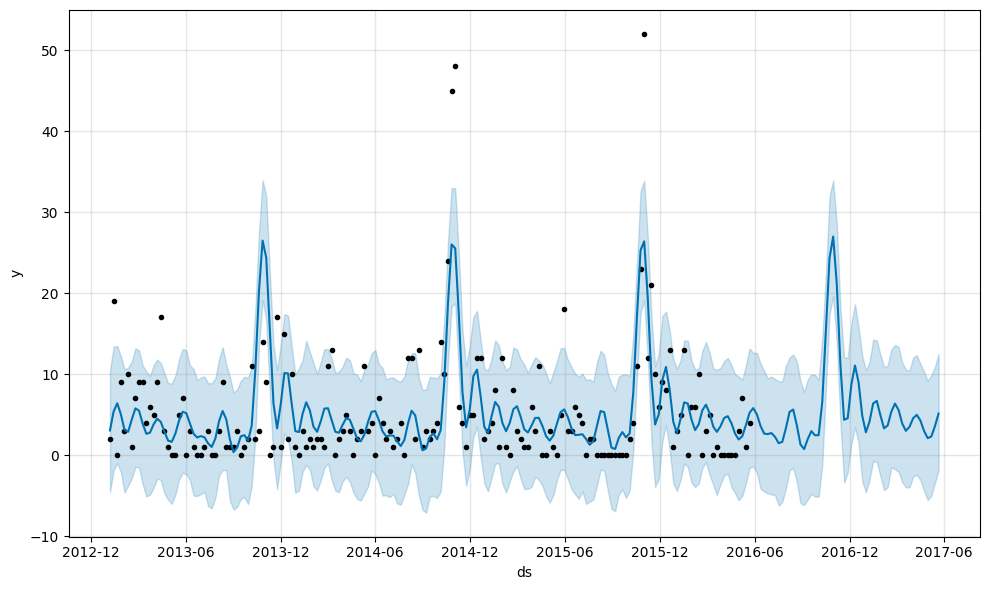

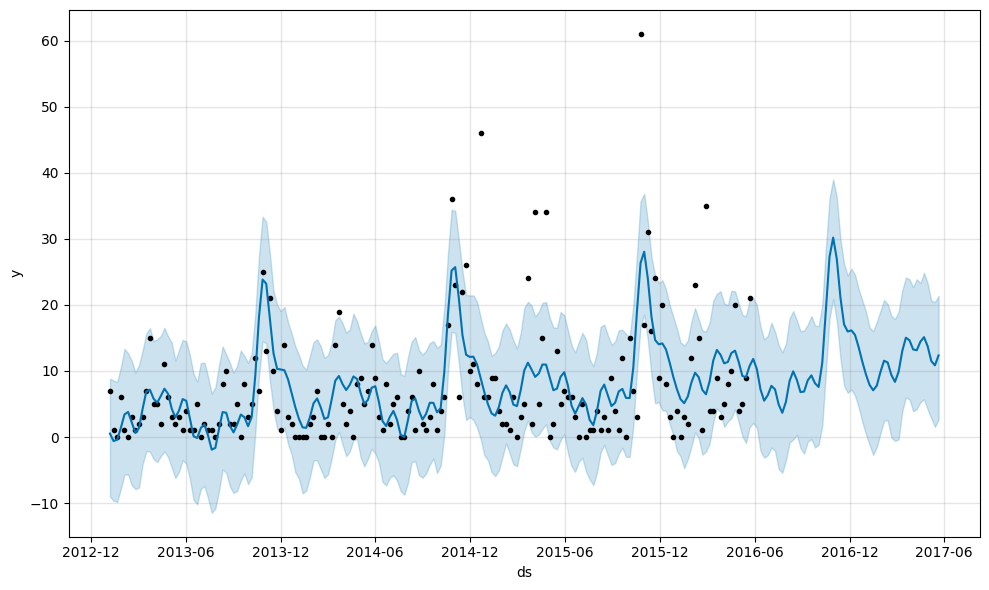

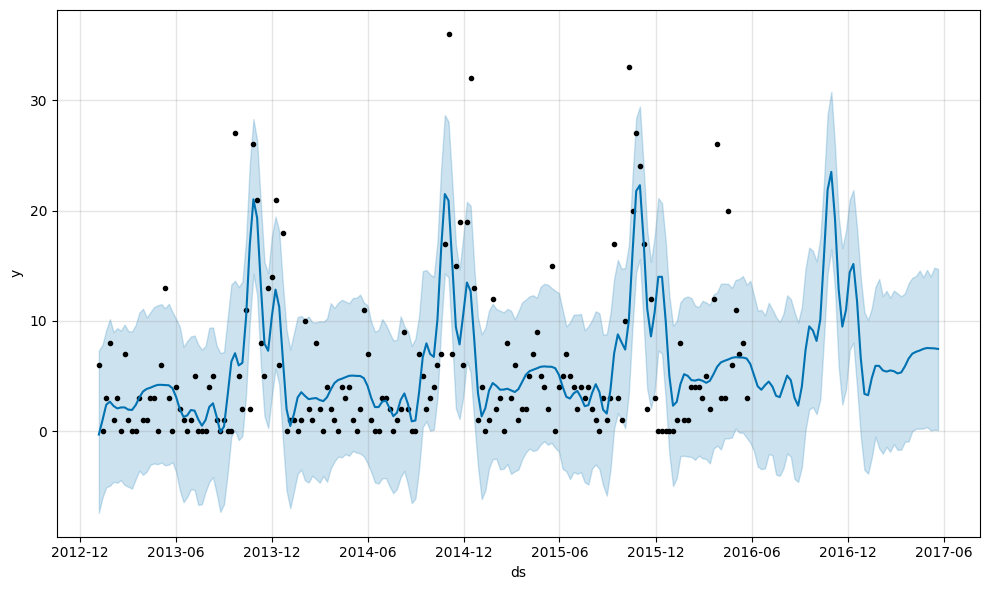

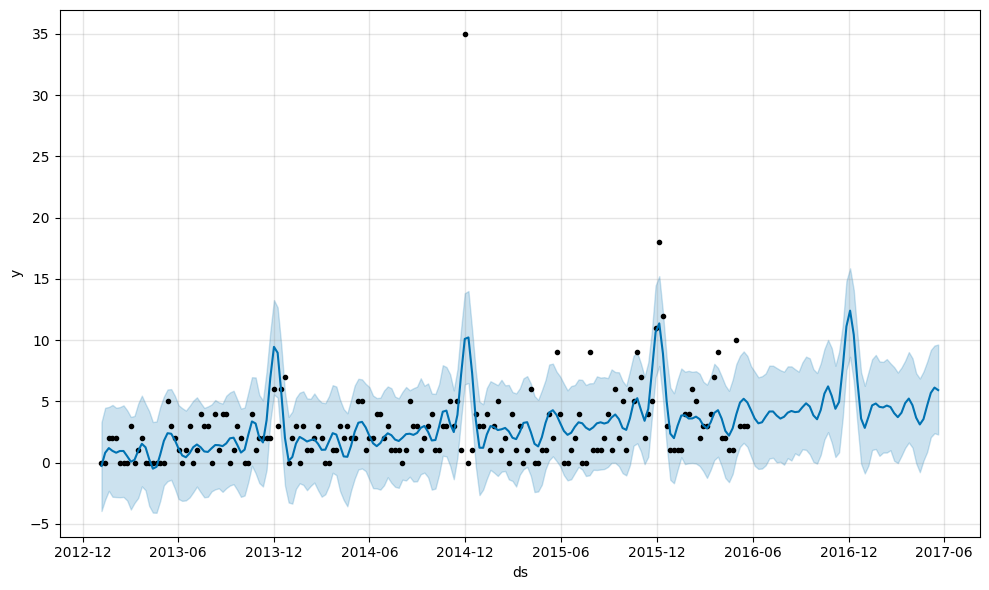

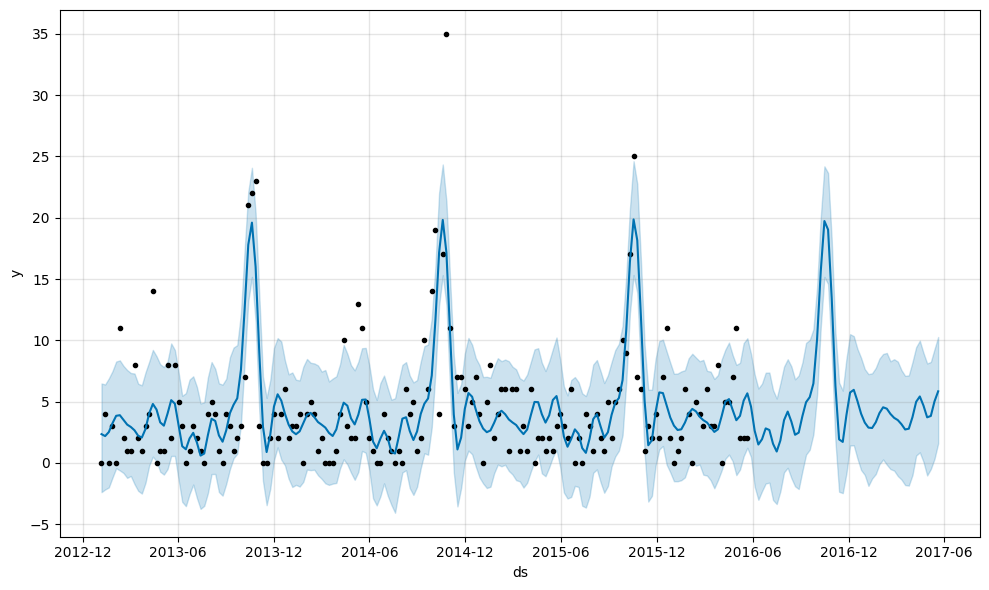

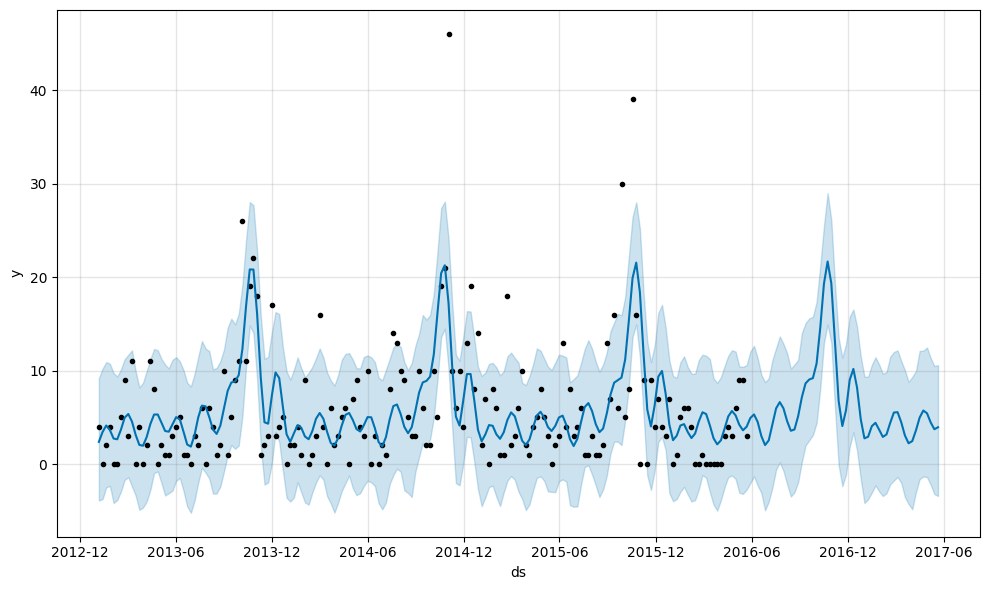

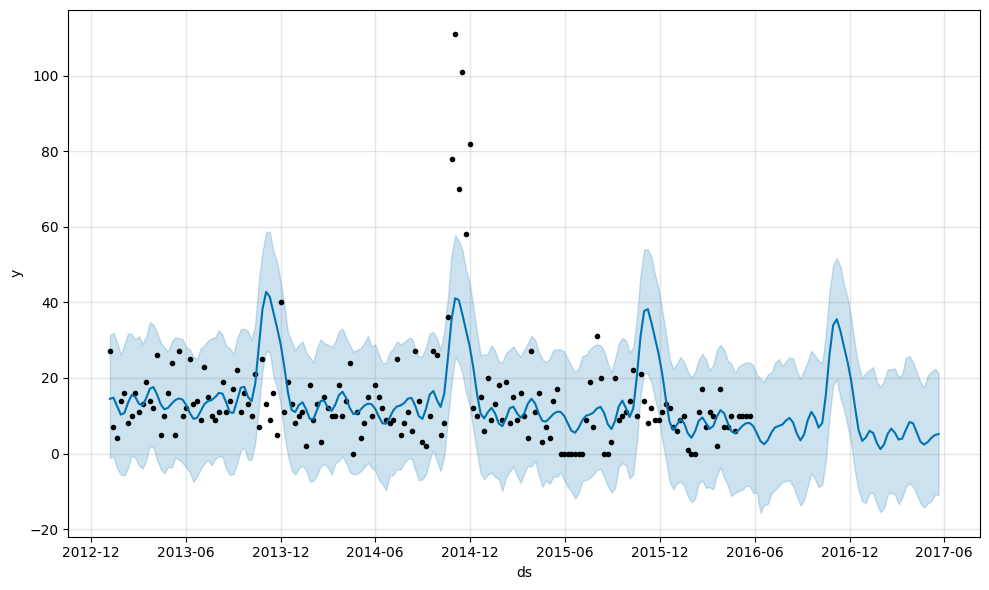

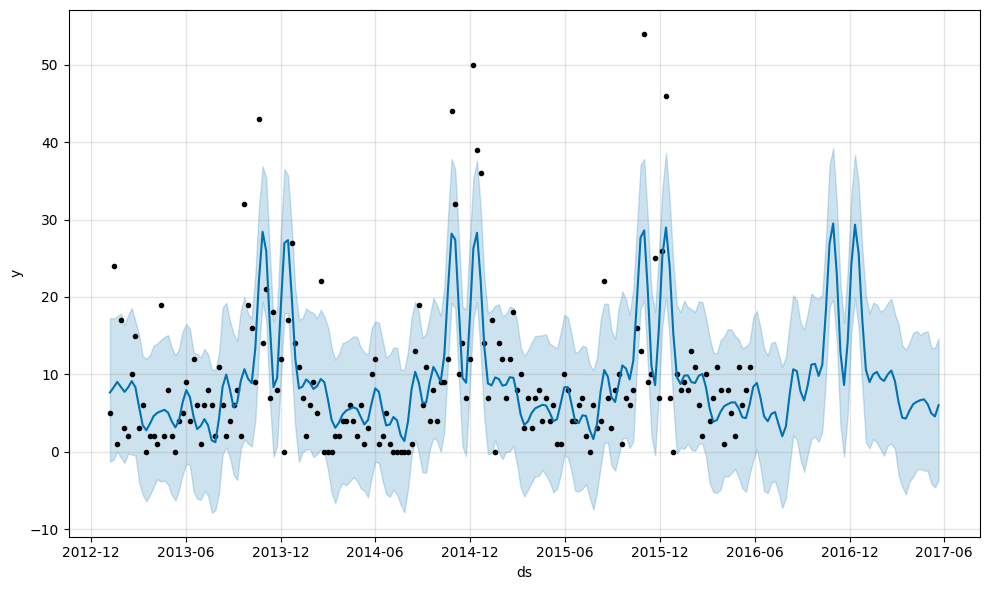

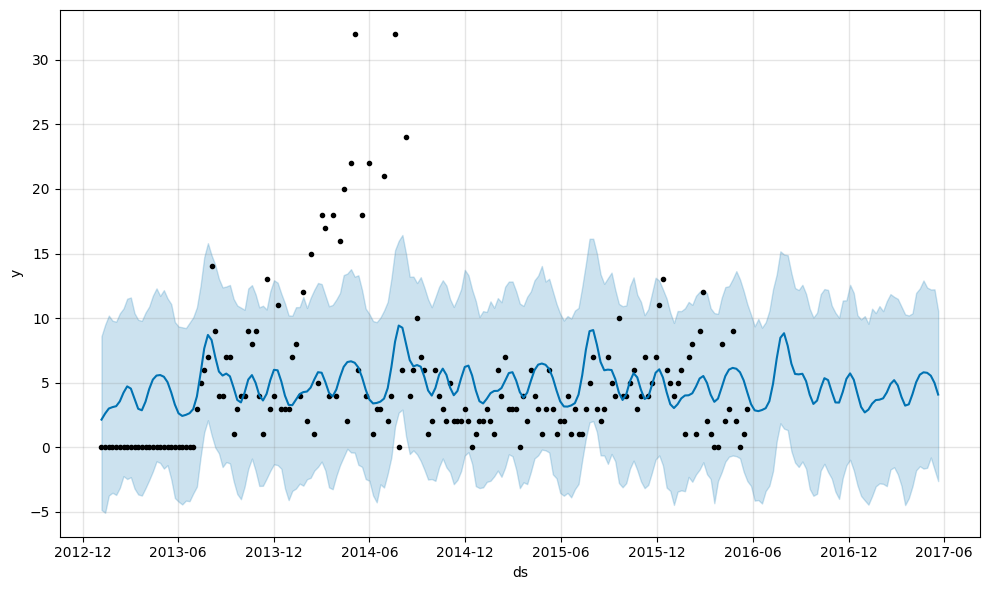

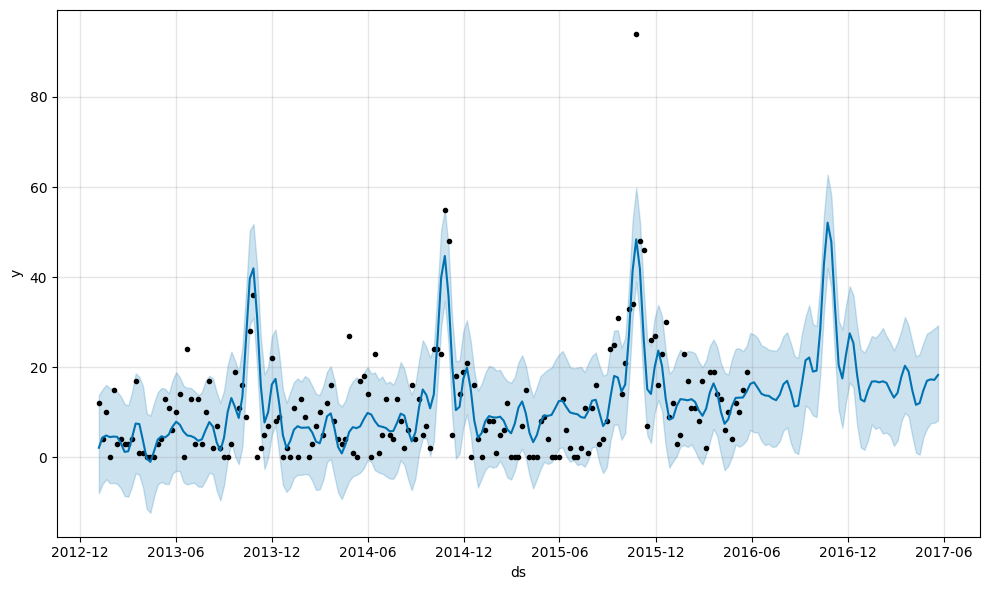

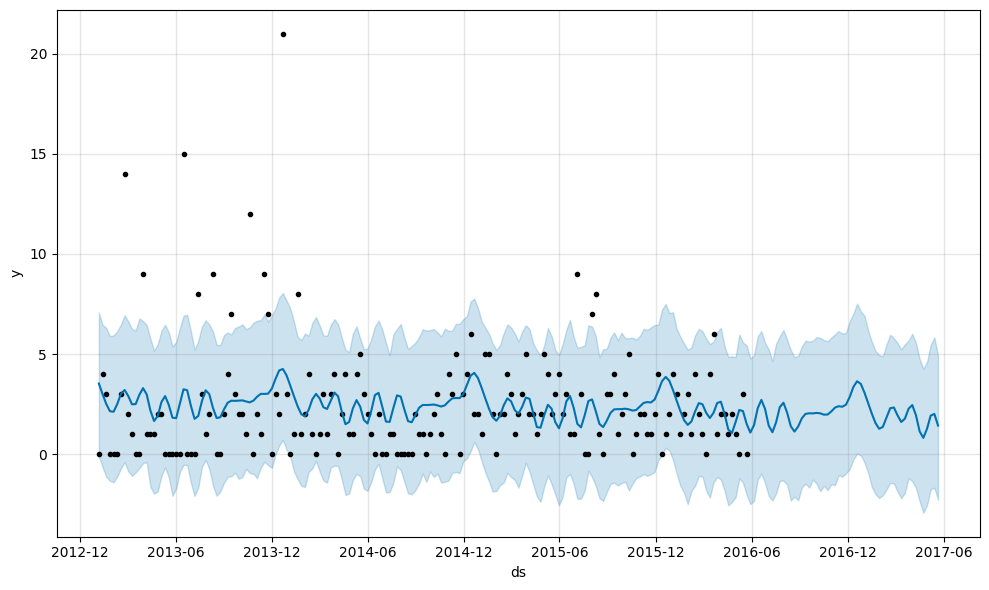

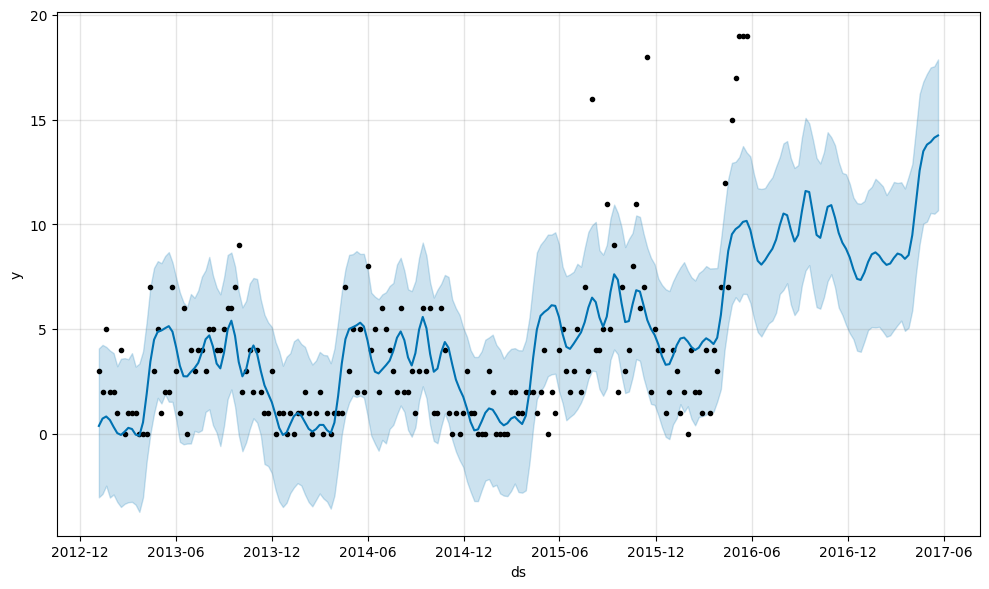

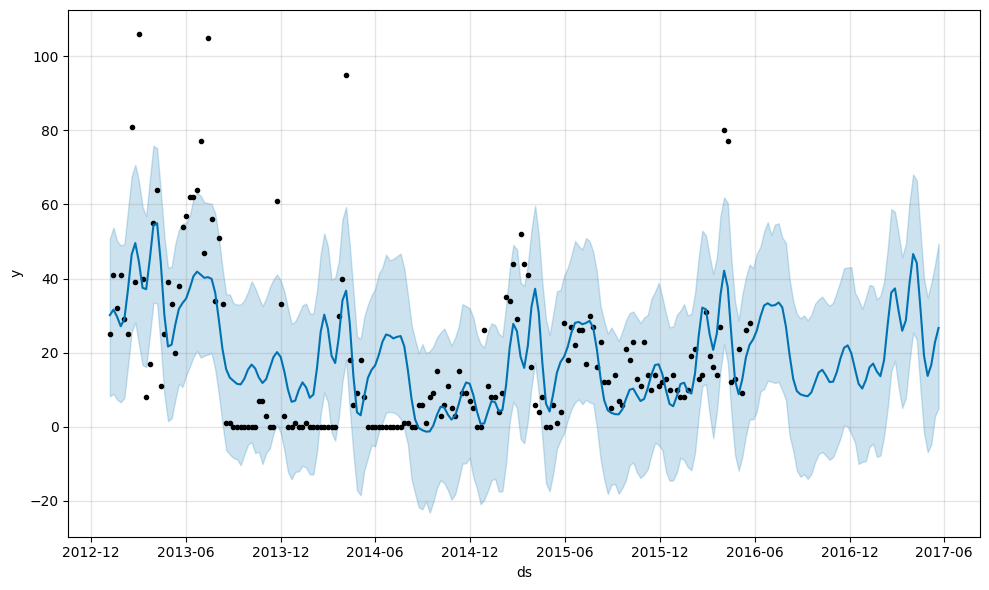

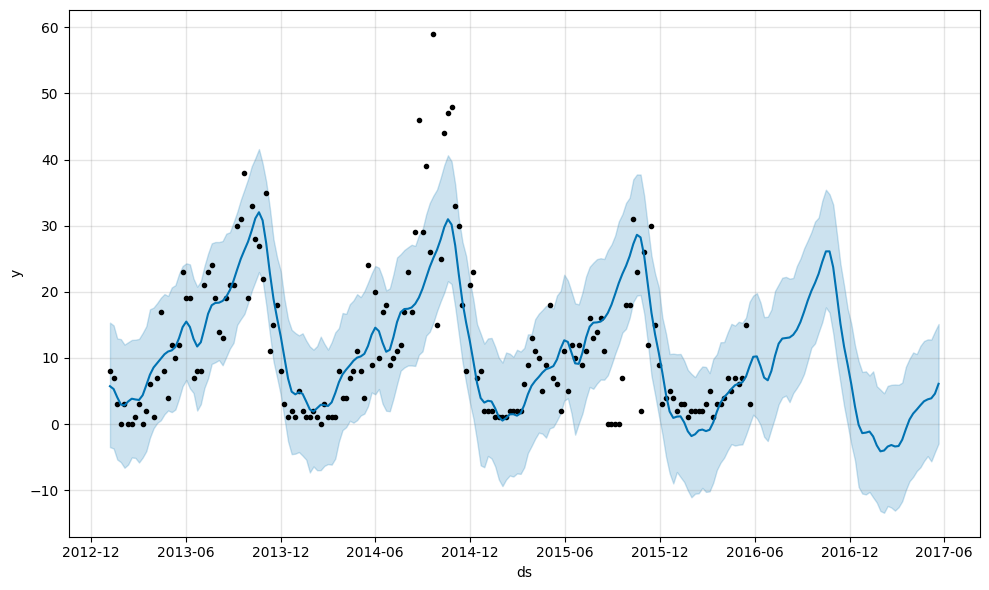

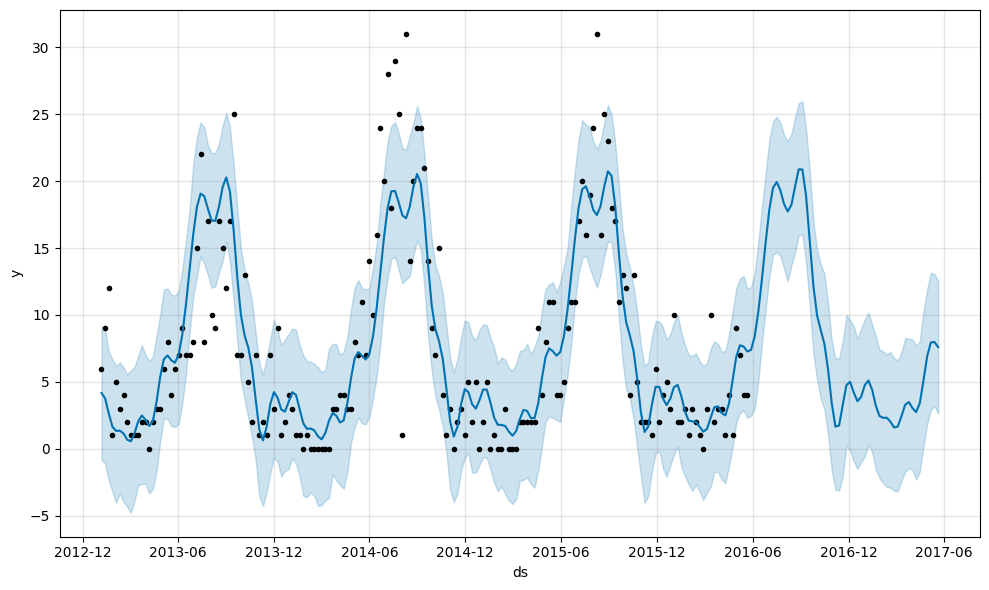

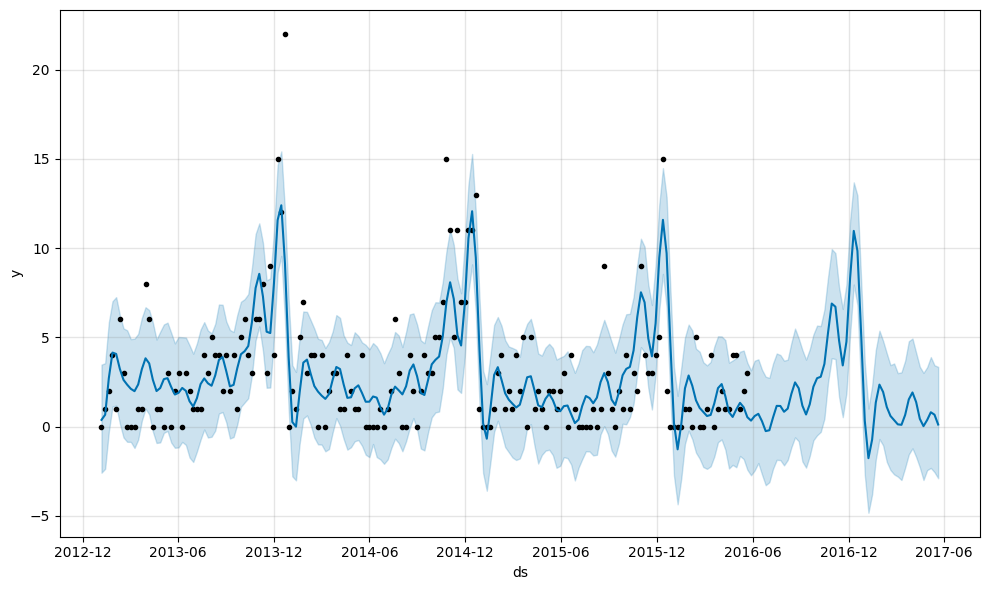

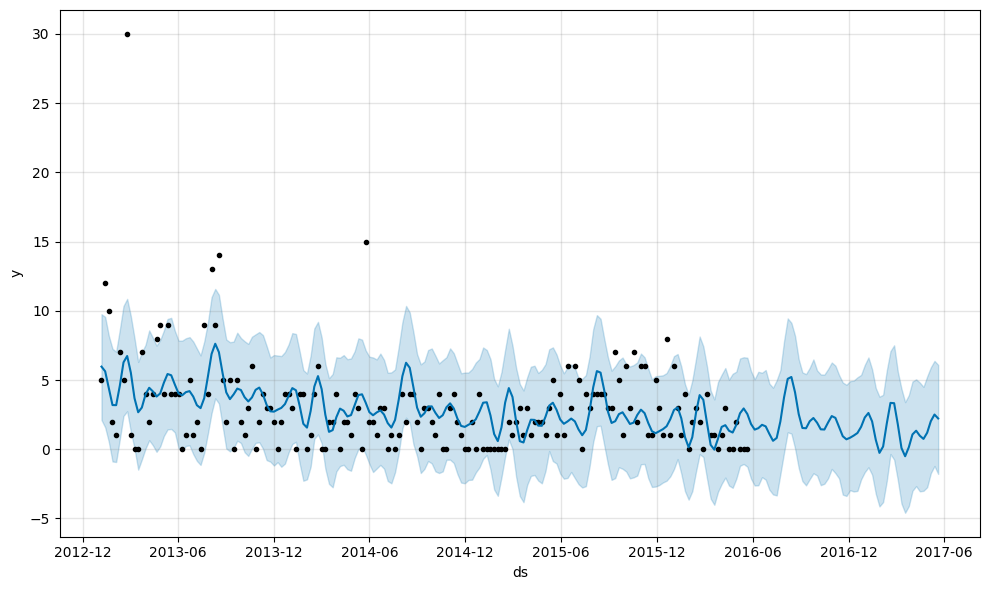

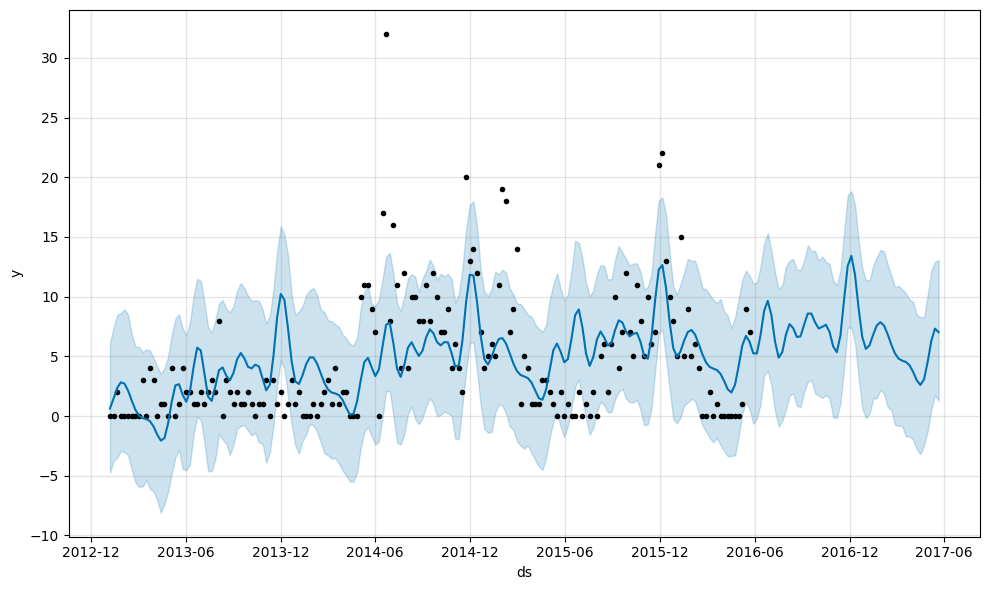

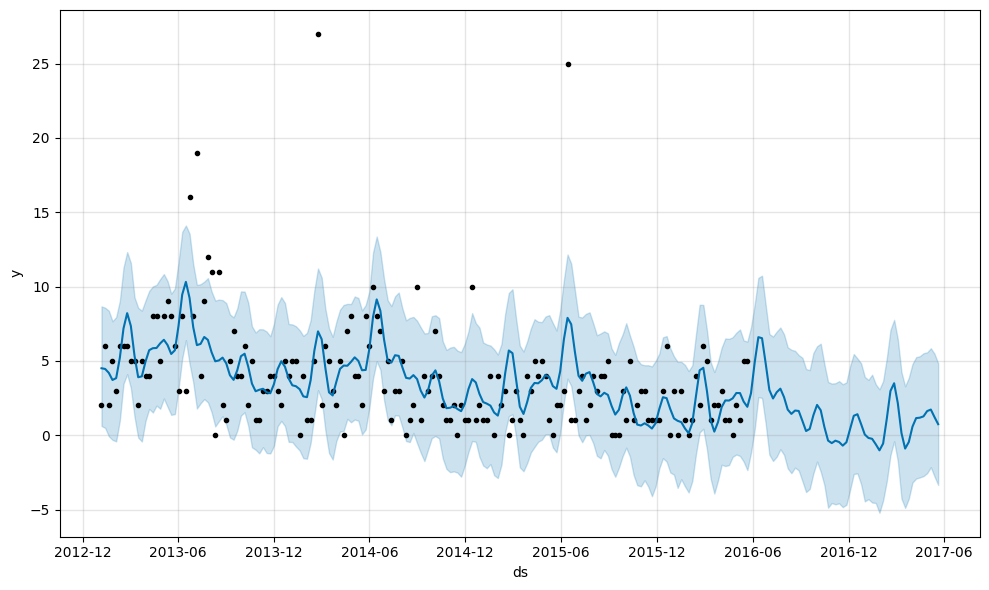

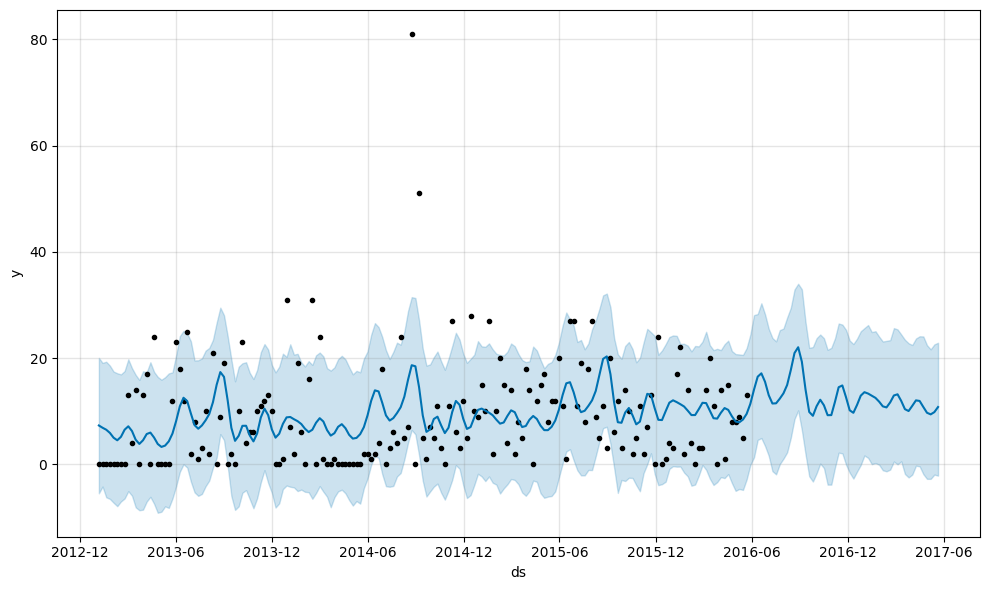

In [ ]:
# simple prophet
for item in ts_dataframe.columns[:20]:
  data = pd.DataFrame()
  data['ds'] = ts_dataframe.index
  data['y'] = ts_dataframe[item].values
  print(data)
  m = Prophet()
  m.fit(data)

  future = m.make_future_dataframe(periods=52, freq='W')
  future.tail()

  forecast = m.predict(future)
  forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
  fig1 = m.plot(forecast)
  #fig2 = m.plot_components(forecast)




In [ ]:
ts_dataframe

,HOBBIES_2_142_CA_4,HOBBIES_2_129_CA_1,HOBBIES_2_129_CA_2,HOBBIES_2_100_CA_1,HOBBIES_2_028_CA_3,HOBBIES_2_124_CA_2,HOUSEHOLD_2_142_CA_2,HOBBIES_2_059_CA_2,HOBBIES_1_119_CA_4,HOBBIES_2_142_CA_2,...,HOBBIES_1_316_CA_4,HOBBIES_1_400_CA_2,HOUSEHOLD_1_274_CA_2,HOBBIES_2_070_CA_2,HOUSEHOLD_1_480_CA_2,HOUSEHOLD_2_067_CA_4,HOBBIES_2_016_CA_2,HOBBIES_2_122_CA_2,HOUSEHOLD_1_133_CA_1,HOUSEHOLD_2_239_CA_4
ds,,,,,,,,,,,,,,,,,,,,,
2013-01-06,2,7,6,0,0,4,27,5,0,12,...,0,0,0,0,0,0,1,0,5,3
2013-01-13,19,1,0,0,4,0,7,24,0,4,...,7,12,0,0,0,0,1,1,8,7
2013-01-20,0,0,3,2,0,2,4,1,0,10,...,11,0,0,0,0,0,0,2,4,5
2013-01-27,9,6,8,2,3,4,14,17,0,0,...,18,6,0,0,0,0,2,0,10,4
2013-02-03,3,1,1,2,0,0,16,3,0,15,...,8,0,0,0,0,0,0,0,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-24,0,20,6,1,7,3,6,2,9,4,...,0,2,4,2,1,2,1,3,2,9
2016-05-01,3,4,11,10,11,6,10,11,2,12,...,0,12,6,0,3,2,1,1,10,9
2016-05-08,7,5,7,3,2,9,10,6,0,10,...,0,2,3,0,0,1,1,2,2,12


In [ ]:
cls_counts.values

array([3338, 3101,    7,    2])

In [ ]:
from prophet import Prophet

data = pd.read_csv('https://raw.githubusercontent.com/acedesci/scanalytics/refs/heads/master/EN/data/M5/processed_data/m5data_CA_1C1S.csv')


m = Prophet()
m.fit(data)

future = m.make_future_dataframe(periods=52, freq='W')
future.tail()


data




INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp36o1eim/ewqyn1gw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp36o1eim/undvuxn_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76479', 'data', 'file=/tmp/tmpp36o1eim/ewqyn1gw.json', 'init=/tmp/tmpp36o1eim/undvuxn_.json', 'output', 'file=/tmp/tmpp36o1eim/prophet_model1eejyvv_/prophet_model-20241223204317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:43:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:43:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,y
0,2013-01-06,1970
1,2013-01-13,2057
2,2013-01-20,1980
3,2013-01-27,2869
4,2013-02-03,3441
...,...,...
172,2016-04-24,3721
173,2016-05-01,3802
174,2016-05-08,3890
175,2016-05-15,4212


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-06,3062.826780,2249.756541,3019.678371,3062.826780,3062.826780,-407.133151,-407.133151,-407.133151,-407.133151,-407.133151,-407.133151,0.0,0.0,0.0,2655.693629
1,2013-01-13,3067.982318,2303.250708,3063.891971,3067.982318,3067.982318,-398.364186,-398.364186,-398.364186,-398.364186,-398.364186,-398.364186,0.0,0.0,0.0,2669.618132
2,2013-01-20,3073.137857,2410.914649,3158.478557,3073.137857,3073.137857,-277.922835,-277.922835,-277.922835,-277.922835,-277.922835,-277.922835,0.0,0.0,0.0,2795.215022
3,2013-01-27,3078.293395,2512.304179,3275.308612,3078.293395,3078.293395,-179.244333,-179.244333,-179.244333,-179.244333,-179.244333,-179.244333,0.0,0.0,0.0,2899.049063
4,2013-02-03,3083.448934,2528.015542,3310.373854,3083.448934,3083.448934,-142.809911,-142.809911,-142.809911,-142.809911,-142.809911,-142.809911,0.0,0.0,0.0,2940.639023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,2017-04-23,4153.821770,3716.965064,4471.634709,4152.090414,4155.378244,-50.832673,-50.832673,-50.832673,-50.832673,-50.832673,-50.832673,0.0,0.0,0.0,4102.989097
225,2017-04-30,4158.661230,3642.369682,4407.836791,4156.869930,4160.277455,-164.668543,-164.668543,-164.668543,-164.668543,-164.668543,-164.668543,0.0,0.0,0.0,3993.992687
226,2017-05-07,4163.500690,3640.546472,4390.758858,4161.638526,4165.156994,-154.384766,-154.384766,-154.384766,-154.384766,-154.384766,-154.384766,0.0,0.0,0.0,4009.115924
227,2017-05-14,4168.340150,3770.085627,4550.365592,4166.428863,4170.052444,-29.517570,-29.517570,-29.517570,-29.517570,-29.517570,-29.517570,0.0,0.0,0.0,4138.822580


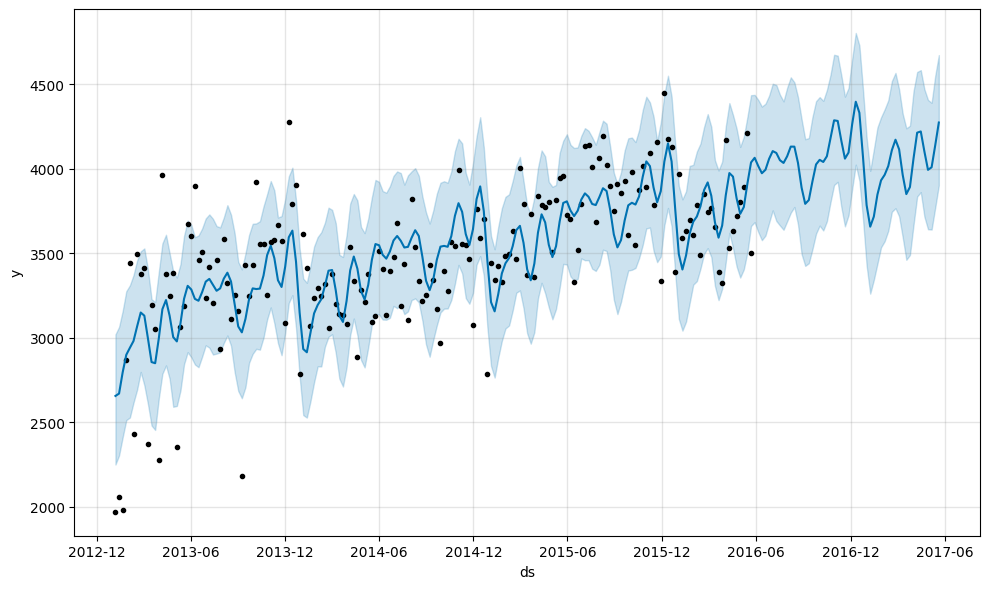

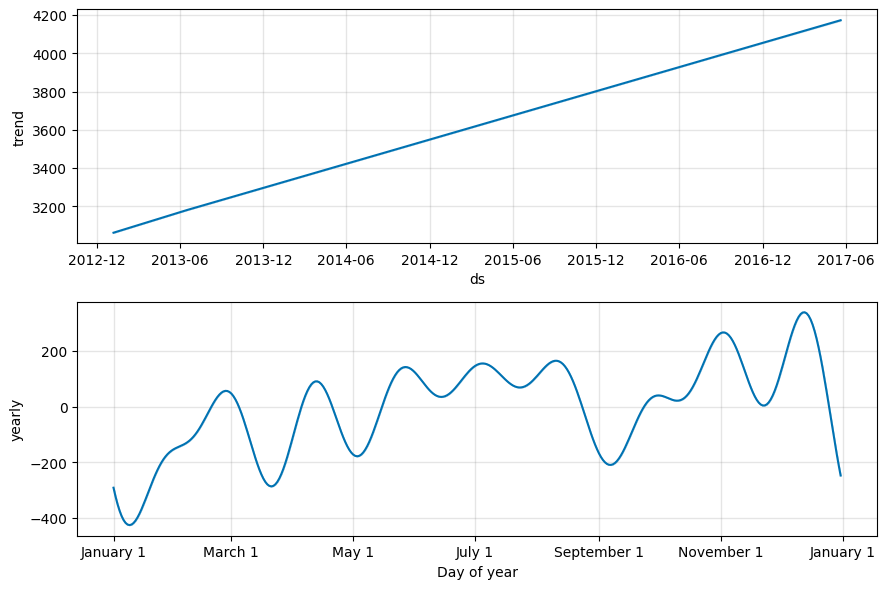

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)
forecast


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp36o1eim/fefw8x6j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp36o1eim/yhlrhu8o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56231', 'data', 'file=/tmp/tmpp36o1eim/fefw8x6j.json', 'init=/tmp/tmpp36o1eim/yhlrhu8o.json', 'output', 'file=/tmp/tmpp36o1eim/prophet_modelzblq_yzy/prophet_model-20241223204336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:43:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:43:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


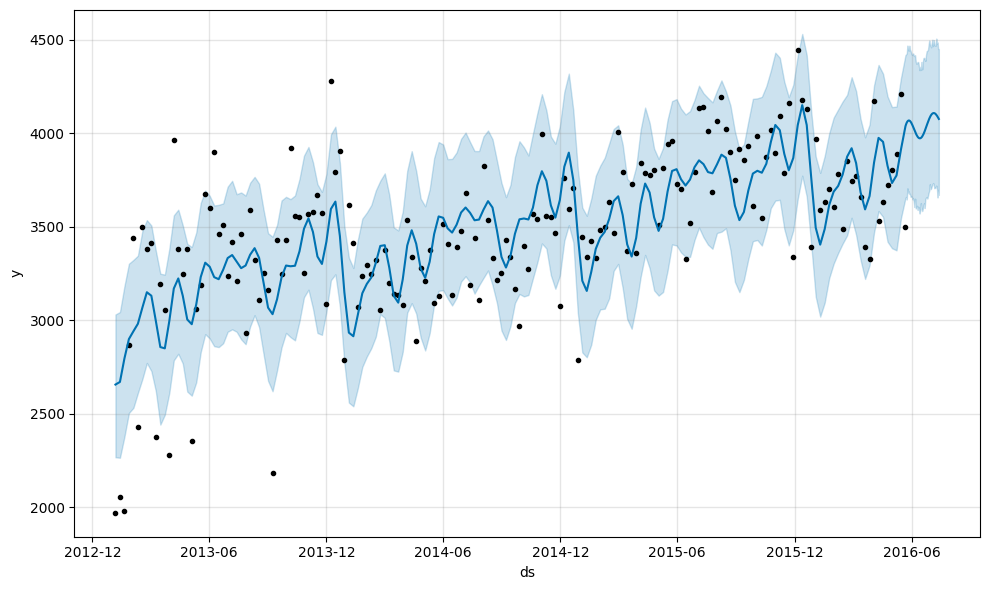

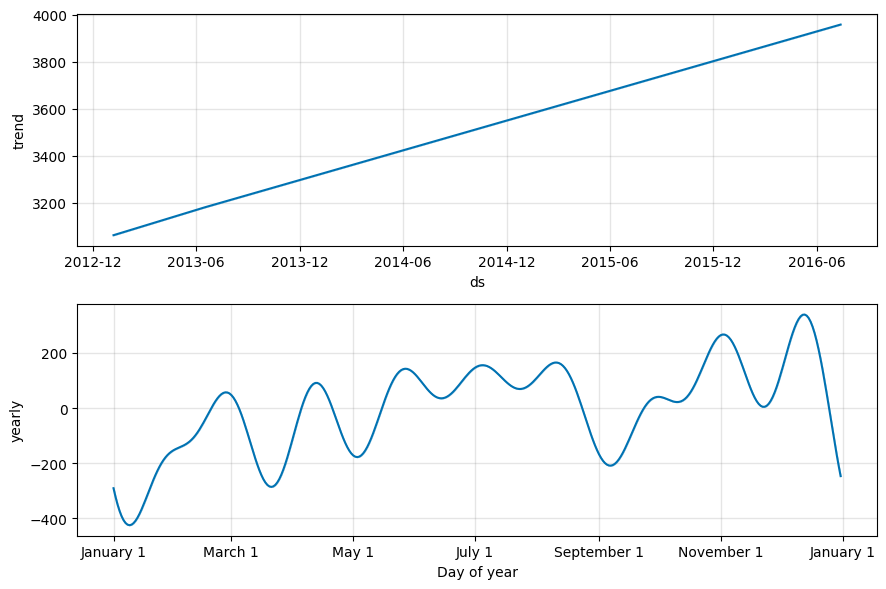

In [ ]:
# simple illustration to go to S1

import pandas as pd
from prophet import Prophet

data = pd.read_csv('https://bit.ly/m5simple')

m = Prophet().fit(data)

future = m.make_future_dataframe(periods=52)
forecast = m.predict(future)

fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [ ]:
future

,ds
0,2014-01-05
1,2014-01-12
2,2014-01-19
3,2014-01-26
4,2014-02-02
...,...
172,2016-07-09
173,2016-07-10
174,2016-07-11
175,2016-07-12


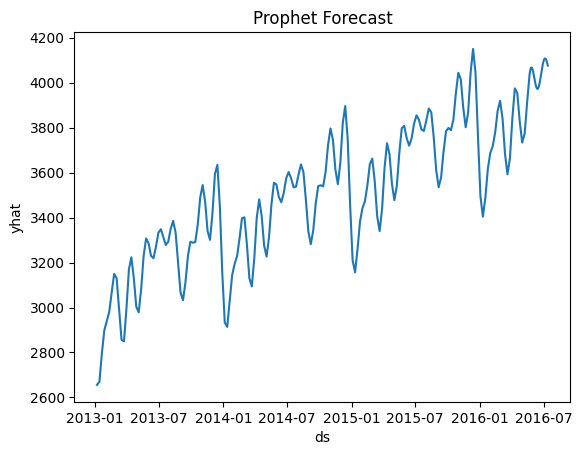

In [ ]:
import matplotlib.pyplot as plt

plt.plot(forecast['ds'], forecast['yhat'])
plt.xlabel('ds')
plt.ylabel('yhat')
plt.title('Prophet Forecast')
plt.show()